# Tecana Technical Analysis Library Demo

This notebook demonstrates how to use the Tecana library for technical analysis of financial market data.

## Installation

First, let's install the library using pip:

In [1]:
!pip install tecana

## Import Libraries

In [3]:
import tecana as tec
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Set up plotting
%matplotlib inline
plt.style.use('seaborn-v0_8-darkgrid')
plt.rcParams['figure.figsize'] = (14, 8)

## Generate Sample OHLCV Data

Let's create a realistic OHLCV (Open-High-Low-Close-Volume) dataset with random price movements:

In [4]:
def generate_ohlc_data(days=200, start_price=100.00):
    np.random.seed(42)  # For reproducibility

    # Generate dates
    dates = pd.date_range(end=pd.Timestamp.now().normalize(), periods=days)

    # Initial price
    price = start_price

    # Lists to store OHLCV data
    opens = []
    highs = []
    lows = []
    closes = []
    volumes = []

    # Generate price movement with some trend and volatility
    for i in range(days):
        # Daily volatility (percentage)
        volatility = max(0.5, min(5.0, 2.0 + 0.5 * np.sin(i/20)))

        # Daily trend component (can create periods of up/down trends)
        trend = 0.1 * np.sin(i/40) + 0.05 * np.sin(i/20)

        # Generate open price with some gap from previous close
        if i == 0:
            open_price = price
        else:
            # Possible gap up/down on open (±1%)
            gap = np.random.normal(0, 0.01)
            open_price = closes[-1] * (1 + gap)

        # Generate daily range and close
        daily_change = np.random.normal(trend, volatility/100)
        close_price = open_price * (1 + daily_change)

        # Generate high and low with realistic relationships
        price_range = max(open_price, close_price) * (volatility/100)
        high_price = max(open_price, close_price) + price_range * np.random.uniform(0.2, 1.0)
        low_price = min(open_price, close_price) - price_range * np.random.uniform(0.2, 1.0)

        # Generate volume (higher on larger price moves)
        base_volume = 100000 + 50000 * np.sin(i/30)  # Cyclical volume pattern
        volume = int(base_volume * (1 + 2 * abs(daily_change)))

        # Round prices to 2 decimal places
        open_price = round(open_price, 2)
        high_price = round(high_price, 2)
        low_price = round(low_price, 2)
        close_price = round(close_price, 2)

        # Store values
        opens.append(open_price)
        highs.append(high_price)
        lows.append(low_price)
        closes.append(close_price)
        volumes.append(volume)

        # Update price for trend continuity
        price = close_price

    # Create DataFrame
    df = pd.DataFrame({
        'open': opens,
        'high': highs,
        'low': lows,
        'close': closes,
        'volume': volumes
    }, index=dates)

    return df

# Generate our test data
ohlcv_data = generate_ohlc_data(days=200, start_price=100.00)

# Display the first few rows
print(f"Generated {len(ohlcv_data)} days of OHLCV data")
ohlcv_data.head()

Generated 200 days of OHLCV data


,open,high,low,close,volume
2024-11-14,100.00,102.58,98.63,100.99,101986
2024-11-15,100.85,101.38,99.03,100.88,101718
2024-11-16,100.64,105.37,98.55,104.91,112085
2024-11-17,105.72,107.03,104.95,106.27,106088
2024-11-18,106.85,110.77,105.85,109.52,111978


Let's plot our price data to verify it looks realistic:

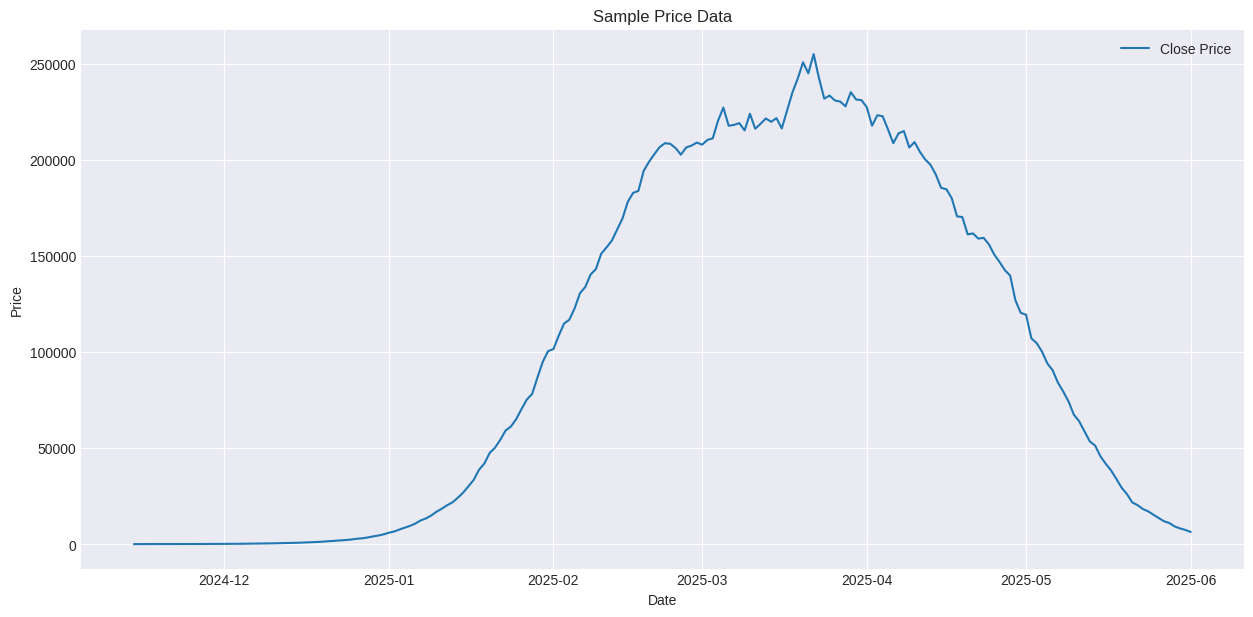

In [5]:
plt.figure(figsize=(15, 7))
plt.plot(ohlcv_data.index, ohlcv_data['close'], label='Close Price')
plt.title('Sample Price Data')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.grid(True)
plt.show()

## Basic Technical Indicators

Let's calculate some basic technical indicators using the Tecana library:

In [ ]:
# Calculate RSI (Relative Strength Index)
df_rsi = tec.rsi(ohlcv_data, 14)
print("RSI added. New columns:", [col for col in df_rsi.columns if col not in ohlcv_data.columns])

# Calculate MACD (Moving Average Convergence Divergence)
df_macd = tec.macd(df_rsi)
print("MACD added. New columns:", [col for col in df_macd.columns if col not in df_rsi.columns])

# Calculate Bollinger Bands
df_bb = tec.bb(df_macd, 20)
print("Bollinger Bands added. New columns:", [col for col in df_bb.columns if col not in df_macd.columns])

# Calculate Average True Range
df_atr = tec.atr(df_bb, 14)
print("ATR added. New columns:", [col for col in df_atr.columns if col not in df_bb.columns])

Let's visualize a couple of these indicators:

In [ ]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(15, 10), gridspec_kw={'height_ratios': [3, 1]})

# Price and Bollinger Bands
ax1.plot(df_atr.index, df_atr['close'], label='Close Price')
ax1.plot(df_atr.index, df_atr['bbh'], 'r--', label='Upper BB')
ax1.plot(df_atr.index, df_atr['bbl'], 'g--', label='Lower BB')
ax1.fill_between(df_atr.index, df_atr['bbh'], df_atr['bbl'], alpha=0.1, color='gray')
ax1.set_title('Price with Bollinger Bands')
ax1.set_ylabel('Price')
ax1.legend()
ax1.grid(True)

# RSI
ax2.plot(df_atr.index, df_atr['rsi'], label='RSI')
ax2.axhline(y=70, color='r', linestyle='-', alpha=0.3)
ax2.axhline(y=30, color='g', linestyle='-', alpha=0.3)
ax2.fill_between(df_atr.index, 70, 30, alpha=0.1, color='gray')
ax2.set_title('RSI (14)')
ax2.set_ylabel('RSI')
ax2.set_ylim(0, 100)
ax2.legend()
ax2.grid(True)

plt.tight_layout()
plt.show()

## Generate Trading Signals

Now, let's calculate some trading signals using the indicators we've generated.
For signal interpretation:
- '-1' indicates a BUY signal (bullish)
- '1' indicates a SELL signal (bearish)

In [ ]:
# Calculate trend signals
df_signals = tec.macd_t(df_atr.copy())  # MACD trend signal
df_signals = tec.rsi_z(df_signals)      # RSI zone signal
df_signals = tec.bb_t(df_signals)       # Bollinger Bands trend signal

# Calculate volatility signal
df_signals = tec.atr_v(df_signals, threshold=1.5)  # ATR volatility signal

# Display the signals
signal_cols = ['macd_t', 'rsi_z', 'bb_t', 'atr_v']
print("Signal summary for last 10 days:")
df_signals[signal_cols].tail(10)

### Explanation of Signals

- **macd_t**: MACD trend signal
  - -1: Buy signal when MACD histogram is positive
  - 1: Sell signal when MACD histogram is negative

- **rsi_z**: RSI zone signal (overbought/oversold)
  - -1: Buy signal when RSI is in oversold zone
  - 1: Sell signal when RSI is in overbought zone

- **bb_t**: Bollinger Bands trend signal
  - -1: Buy signal when price touches lower band with positive momentum
  - 1: Sell signal when price touches upper band with negative momentum
  
- **atr_v**: ATR volatility signal (not a buy/sell signal)
  - 1: Indicates high volatility (ATR above threshold)
  - NaN: Normal volatility

## Using the Custom Method

The `custom` method allows applying multiple indicators and signals in a single call.

In [ ]:
# Use the custom method to apply multiple indicators at once
custom_df = tec.custom(ohlcv_data,
    ['rsi', 14],                  # RSI with window=14
    ['macd'],                     # MACD with default parameters
    ['bb', 20, 2],                # Bollinger Bands with window=20 and std=2
    ['atr', {'window': 14}]       # ATR with window=14 (using kwargs)
)

# Add multiple signals using custom method
custom_signals = tec.custom(custom_df,
    ['rsi_z'],                    # RSI zone signal (using default parameters)
    ['macd_t'],                   # MACD trend signal
    ['bb_t', 14],                 # BB trend signal with custom parameter
    ['atr_v', 1.2]                # ATR volatility signal with custom threshold
)

print("\nIndicators added:")
print([col for col in custom_df.columns if col not in ohlcv_data.columns])

print("\nSignals added:")
print([col for col in custom_signals.columns if col not in custom_df.columns])

# View signal values
signal_cols = ['rsi_z', 'macd_t', 'bb_t', 'atr_v']
print("\nSignals for the last 5 days:")
custom_signals[signal_cols].tail()

## Visualize Signals On Price Chart

Let's visualize buy and sell signals on a price chart:

In [ ]:
# Get buy and sell signals from MACD trend
buy_signals = custom_signals[custom_signals['macd_t'] == -1].index
sell_signals = custom_signals[custom_signals['macd_t'] == 1].index

# Plot price with signals
plt.figure(figsize=(15, 7))
plt.plot(custom_signals.index, custom_signals['close'], label='Close Price', alpha=0.8)

# Plot buy signals (green arrows)
plt.scatter(buy_signals, custom_signals.loc[buy_signals, 'close'],
            marker='^', color='green', s=100, label='Buy Signal', alpha=0.8)

# Plot sell signals (red arrows)
plt.scatter(sell_signals, custom_signals.loc[sell_signals, 'close'],
            marker='v', color='red', s=100, label='Sell Signal', alpha=0.8)

plt.title('Price Chart with MACD Buy/Sell Signals')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.grid(True)
plt.show()

## Combined Signal Strategy

Let's create a simple strategy that combines multiple signals:

In [ ]:
# Create a combined signal (Buy when both MACD and RSI agree)
custom_signals['combined_signal'] = 0

# Strong buy signal when both MACD and RSI suggest buying
custom_signals.loc[(custom_signals['macd_t'] == -1) &
                   (custom_signals['rsi_z'] == -1), 'combined_signal'] = -1

# Strong sell signal when both MACD and RSI suggest selling
custom_signals.loc[(custom_signals['macd_t'] == 1) &
                   (custom_signals['rsi_z'] == 1), 'combined_signal'] = 1

# Count the number of buy and sell signals
buy_count = (custom_signals['combined_signal'] == -1).sum()
sell_count = (custom_signals['combined_signal'] == 1).sum()

print(f"Combined strategy generated {buy_count} buy signals and {sell_count} sell signals")

# Show the latest signals
last_days = 15
print(f"\nSignals for the last {last_days} days:")
custom_signals[['close', 'macd_t', 'rsi_z', 'combined_signal']].tail(last_days)

## Conclusion

In this demo, we've shown how to:

1. Install and import the Tecana library
2. Generate sample OHLCV data
3. Calculate various technical indicators
4. Generate trading signals
5. Use the powerful `custom` method to apply multiple indicators and signals at once
6. Create a simple combined trading strategy

The Tecana library offers a comprehensive set of technical indicators and signals with a clean, easy-to-use API. The `custom` method makes it particularly efficient to work with multiple indicators simultaneously.